# TIME SERIES
### Personal Code

- [1. LOAD DATA](#1)
- [2. FEATURES ENGINEERING](#2)
- [3. SPLIT DATA](#3)
- [4. NORMALIZE DATA](#4)
- [5. CREATE WINDOW DATASET](#5)
- [6. CREATE PERSONAL CALLBACK](#6)
- [7. MODEL 1: DENSE MODEL](#7)
- [8. MODEL 2: CNN MODEL](#8)
- [9. MODEL 3: RNN MODEL](#9)

### The page from where information will be obtained is:
https://www.bgc-jena.mpg.de/wetter/

This dataset contains 14 different characteristics, such as air temperature, atmospheric pressure and humidity. These were collected every 10 minutes starting in 2003. For efficiency, it will use only data collected between 2009 and 2016.

<a name='1'></a>
## 1. LOAD DATA

In [1]:
import os
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
# Use the tf.keras.utils to download the data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',  #Link for the data
    fname='jena_climate_2009_2016.csv.zip',                                                               #File name
    extract=True)

csv_path, _ = os.path.splitext(zip_path)                                        #Split the data

df = pd.read_csv(csv_path)                                                      #Read the csv and save

# The initial data set is distributed every 10 minutes, the data will be filtered for each hour.
df = df[5::6]                                                                   #starting from index 5 take every 6th record

#Return item and drop from frame.
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [3]:
# Check statistical information of the features
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


The values of "wv" and "max. wv" have minimum outliers (-9999.00).

In [4]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

<a name='2'></a>
## 2. FEATURES ENGINEERING

In [5]:
''' WIND
It's more useful to convert the wind direction and wind speed columns into a wind vector.
'''

wv = df.pop('wv (m/s)')                      #Return the "wv" from the dataframe
max_wv = df.pop('max. wv (m/s)')             #Return the "max. wv" from the dataframe

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180      #Return the "wd" from the dataframe

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [6]:
''' HOUR
Periodic signals will be obtained to obtain better information on the time data. 
Sine and cosine transformations will be used.
'''

# Column "Date Time" will be converted in seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

<a name='3'></a>
## 3. SPLIT DATA

In [8]:
#Obtain the column indices from the dataframe
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)                          #Number of data
train_df = df[0:int(n*0.7)]          #Split 70% for training set
val_df = df[int(n*0.7):int(n*0.9)]   #Split 20% for validation set
test_df = df[int(n*0.9):]            #Split the rest of 10% for testing set

num_features = df.shape[1]           #Specify the number of features

df.head()                            #Display the first four rows of data

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


<a name='4'></a>
## 4. NORMALIZE DATA

In [9]:
#Obtain the mean and standard deviation value from the DataFrame
train_mean = train_df.mean()
train_std = train_df.std()

#Data normalization with the mean / std values
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<a name='5'></a>
## 5. CREATE WINDOW DATASET

In [10]:
# Parameters
window_size = 3
batch_size = 32
shuffle_buffer_size = 10000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1],                         #Use all columns except the last one (Prediction column)
                                          tf.reshape(window[-1][1], [1,1])))   #Predict only one in the future and from the column [1] of the dataframe

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1) # Representing the maximum number of elements that will be buffered when prefetching.
    
    return dataset

# Generate the dataset windows
train_set = windowed_dataset(train_df, window_size, batch_size, shuffle_buffer_size)

# Generate data windows of the validation set
val_set = windowed_dataset(val_df, window_size, batch_size, shuffle_buffer_size)

<a name='6'></a>
## 6. CREATE PERSONAL CALLBACK

In [11]:
def Personal_callback(model_name, metrics, threshold_metric, ep, lr_i=0.001):
    """Generate a list of personal Callbacks to use in the training process
    Args:
        model_name (string)        - Contain the name of the model
        metrics (string)           - Contains the metric to be evaluated
        threshold_metric (string)  - Specify the threshold for the metric
        ep (int)                   - The number of epoch in the training process
        lr_i                       - Specify the initial learning rate
        
    Returns:
        A list of callback functions to use in the training process
    """

    """
    Stop training
    """
    class stop_training(tf.keras.callbacks.Callback):                                               #Define the class
        def on_epoch_end(self, epoch, logs = {}):                                                   #Use in the end of the epoch
            if(logs.get(metrics)<threshold_metric and logs.get('val_'+metrics) <threshold_metric):  #Define threshold for metrics
                print("\Cancelling training!")
                self.model.stop_training = True                                                     #Stop the training process
    stop_train = stop_training()
    
    """
    Learning Rate Decay
    """
    global LR_init         #Define global variable
    LR_init=lr_i           #Specify the initial learning rate
    
    class learning_decay(tf.keras.callbacks.Callback):                      #Define the class
        def on_epoch_end(self, batch, logs={}):                             #Use in the end of the epoch
            lr = self.model.optimizer.lr                                    #Call the leraning rate from the model
            global LR_init                                                  #Define global variable
            new_lr = (LR_init) * 10.**(-(batch+1.)/(ep*10))                 #Define the learning rate decay function
            if lr > new_lr:                                                 #If the previous lr is greater than actual lr
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) #Update the value of the learning rate
            else:
                LR_init=lr                                                  #This used because we use the callback 'ReduceLROnPlateau'

    lr_decay = learning_decay()
    
    """
    Reduce Learning Rate
    """
    # Creating learning rate reduction callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= metrics,   #Specify the metrics
                                                     factor=0.2,         # new_lr = lr * factor
                                                     patience=2,         # number of epochs with no improvement after which learning rate will be reduced
                                                     verbose=1,          # print out when learning rate goes down 
                                                     min_lr=1e-7)        # lower bound on the learning rate
    """
    Early Stopping
    """
    # Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 4 epochs
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = metrics,         # watch the val loss metric
                                                  patience = 4,                  # if val loss decreases for 4 epochs in a row, stop training
                                                  min_delta = 0.0001,            # Minimum change in the monitored quantity to qualify as an improvement
                                                  restore_best_weights = False,  #Don't sabe the best weights, because we use the callback "ModelCheckpoint"
                                                     verbose=1)                  #Display a message
    """
    Model Checkpoint
    """
    # Create ModelCheckpoint callback to save model's progress
    checkpoint_path = "checkpoint_path/"+ model_name +"/checkpoint.ckpt"          # saving weights requires ".ckpt" extension
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor=metrics,         # save the model weights with best metric
                                                         save_weights_only=True,  # set to False to save the entire model
                                                         save_best_only=True,     # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch",       # save every epoch
                                                         verbose=0)               # don't print out whether or not model is being saved 
    
    return [stop_train, lr_decay, reduce_lr, early_stopping, checkpoint]

<a name='7'></a>
## 7. MODEL 1: DENSE MODEL

In [27]:
#BUILD THE MODEL
dense_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[window_size,num_features]),
    tf.keras.layers.Dense(units=32, activation="relu"), 
    tf.keras.layers.Dense(units=32, activation="relu"), 
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

#COMPILE THE MODEL
dense_model.compile(loss=tf.losses.MeanSquaredError(),   # The loss value that will be minimized by the model
                      optimizer=tf.optimizers.Adam(),    # Define the optimizer
                      metrics=['mae'])                   # List of metrics to be evaluated by the model during training and testing.

#SAVE THE INITIAL WEIGHTS (Use when try with different models)
InitialW_dense = dense_model.get_weights()

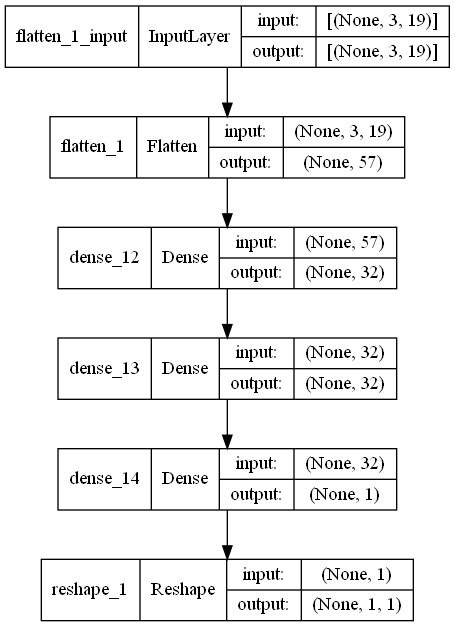

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(dense_model, show_shapes=True)

In [29]:
#Load the initial weights
dense_model.set_weights(InitialW_dense)

#Reset the value of learning rate in the model
tf.keras.backend.set_value(dense_model.optimizer.lr, 0.001)

#Fit the model
history = dense_model.fit(train_set, 
                            epochs=10,
                            validation_data=val_set,
                            callbacks=Personal_callback(model_name='dense/FIT_1', 
                                                        metrics='mae', 
                                                        threshold_metric=0.04,
                                                        ep=10)
                         )

#Save the model weights (Use when you train again)
FIT_1_dense=dense_model.get_weights()

Epoch 1/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0180 - mae: 0.0942 - val_loss: 0.0088 - val_mae: 0.0684 - lr: 9.7724e-04
Epoch 2/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0083 - mae: 0.0666 - val_loss: 0.0075 - val_mae: 0.0627 - lr: 9.5499e-04
Epoch 3/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0076 - mae: 0.0626 - val_loss: 0.0071 - val_mae: 0.0610 - lr: 9.3325e-04
Epoch 4/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0072 - mae: 0.0606 - val_loss: 0.0071 - val_mae: 0.0610 - lr: 9.1201e-04
Epoch 5/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0070 - mae: 0.0597 - val_loss: 0.0066 - val_mae: 0.0556 - lr: 8.9125e-04
Epoch 6/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0068 - mae: 0.0582 - val_loss: 0.0067 - val_mae: 0.0584 - lr: 8.7096e-04
Epoch 7/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0067 - ma

In [30]:
#Load the 'FIT_1' weights
dense_model.set_weights(FIT_1_dense)

#Reset the value of learning rate in the model
tf.keras.backend.set_value(dense_model.optimizer.lr, 0.001)

#Fit the model
history = dense_model.fit(train_set, 
                            epochs=10,
                            validation_data=val_set,
                            callbacks=Personal_callback(model_name='dense/FIT_2', 
                                                        metrics='mae', 
                                                        threshold_metric=0.04,
                                                        ep=10)
                         )

#Save the model weights (Use when you train again)
FIT_2_dense = dense_model.get_weights()

Epoch 1/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0065 - mae: 0.0568 - val_loss: 0.0061 - val_mae: 0.0542 - lr: 9.7724e-04
Epoch 2/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0064 - mae: 0.0562 - val_loss: 0.0061 - val_mae: 0.0539 - lr: 9.5499e-04
Epoch 3/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0064 - mae: 0.0561 - val_loss: 0.0060 - val_mae: 0.0543 - lr: 9.3325e-04
Epoch 4/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0063 - mae: 0.0555 - val_loss: 0.0061 - val_mae: 0.0547 - lr: 9.1201e-04
Epoch 5/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0062 - mae: 0.0553 - val_loss: 0.0065 - val_mae: 0.0584 - lr: 8.9125e-04
Epoch 6/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0062 - mae: 0.0550 - val_loss: 0.0060 - val_mae: 0.0537 - lr: 8.7096e-04
Epoch 7/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0062 - ma

In [31]:
# Save a model using the HDF5 format
dense_model.save("best_model/best_dense.h5") # note the addition of '.h5' on the end

h5_dense_model = tf.keras.models.load_model("best_model/best_dense.h5")
h5_dense_evaluate = h5_dense_model.evaluate(val_set, batch_size=32)

438/438 [==============================] - 2s 4ms/step - loss: 0.0061 - mae: 0.0547


<a name='8'></a>
## 8. MODEL 2: CNN MODEL

In [32]:
#BUILD THE MODEL
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size,num_features)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

#COMPILE THE MODEL
cnn_model.compile(loss=tf.losses.MeanSquaredError(),    # The loss value that will be minimized by the model
                      optimizer=tf.optimizers.Adam(),    # Define the optimizer
                      metrics=['mae'])                   # List of metrics to be evaluated by the model during training and testing.

#SAVE THE INITIAL WEIGHTS (Use when try with different models)
InitialW_cnn = cnn_model.get_weights()

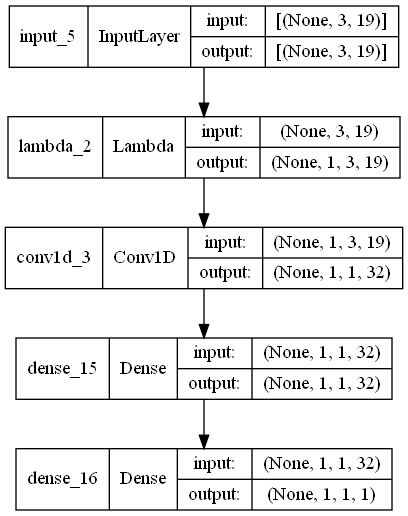

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(cnn_model, show_shapes=True)

In [34]:
#Load the initial weights
cnn_model.set_weights(InitialW_cnn)

#Reset the value of learning rate in the model
tf.keras.backend.set_value(cnn_model.optimizer.lr, 0.001)

#Fit the model
history = cnn_model.fit(train_set, 
                            epochs=10,
                            validation_data=val_set,
                            callbacks=Personal_callback(model_name='CNN/FIT_1', 
                                                        metrics='mae', 
                                                        threshold_metric=0.04,
                                                        ep=10)
                         )

#Save the model weights (Use when you train again)
FIT_1_cnn=cnn_model.get_weights()

Epoch 1/10
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0237 - mae: 0.0980 - val_loss: 0.0083 - val_mae: 0.0658 - lr: 9.7724e-04
Epoch 2/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0082 - mae: 0.0661 - val_loss: 0.0076 - val_mae: 0.0628 - lr: 9.5499e-04
Epoch 3/10
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0075 - mae: 0.0622 - val_loss: 0.0069 - val_mae: 0.0582 - lr: 9.3325e-04
Epoch 4/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0072 - mae: 0.0605 - val_loss: 0.0065 - val_mae: 0.0570 - lr: 9.1201e-04
Epoch 5/10
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0069 - mae: 0.0590 - val_loss: 0.0065 - val_mae: 0.0562 - lr: 8.9125e-04
Epoch 6/10
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0068 - mae: 0.0583 - val_loss: 0.0067 - val_mae: 0.0584 - lr: 8.7096e-04
Epoch 7/10
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0067 - ma

In [35]:
# Save a model using the HDF5 format
cnn_model.save("best_model/best_cnn.h5") # note the addition of '.h5' on the end

h5_cnn_model = tf.keras.models.load_model("best_model/best_cnn.h5")
h5_cnn_evaluate = h5_cnn_model.evaluate(val_set, batch_size=32)

438/438 [==============================] - 3s 5ms/step - loss: 0.0076 - mae: 0.0624


<a name='9'></a>
## 9. MODEL 3: RNN MODEL

In [36]:
#BUILD THE MODEL
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(window_size,num_features)),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

#COMPILE THE MODEL
rnn_model.compile(loss=tf.losses.MeanSquaredError(),     # The loss value that will be minimized by the model
                      optimizer=tf.optimizers.Adam(),    # Define the optimizer
                      metrics=['mae'])                   # List of metrics to be evaluated by the model during training and testing.

#SAVE THE INITIAL WEIGHTS (Use when try with different models)
InitialW_rnn = rnn_model.get_weights()

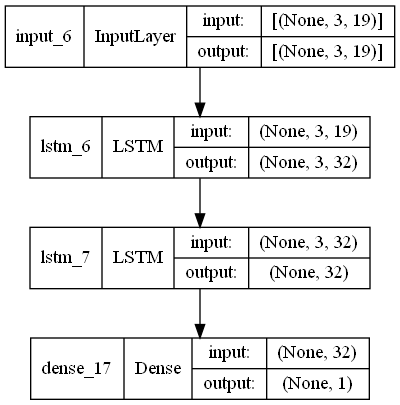

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(rnn_model, show_shapes=True)

In [38]:
#Load the initial weights
rnn_model.set_weights(InitialW_rnn)

#Reset the value of learning rate in the model
tf.keras.backend.set_value(rnn_model.optimizer.lr, 0.001)

#Fit the model
history = rnn_model.fit(train_set, 
                            epochs=10,
                            validation_data=val_set,
                            callbacks=Personal_callback(model_name='RNN/FIT_1', 
                                                        metrics='mae', 
                                                        threshold_metric=0.04,
                                                        ep=10)
                         )

#Save the model weights (Use when you train again)
FIT_1_rnn=rnn_model.get_weights()

Epoch 1/10
1534/1534 [==============================] - 24s 13ms/step - loss: 0.0281 - mae: 0.1032 - val_loss: 0.0082 - val_mae: 0.0672 - lr: 9.7724e-04
Epoch 2/10
1534/1534 [==============================] - 20s 13ms/step - loss: 0.0074 - mae: 0.0617 - val_loss: 0.0065 - val_mae: 0.0579 - lr: 9.5499e-04
Epoch 3/10
1534/1534 [==============================] - 20s 13ms/step - loss: 0.0067 - mae: 0.0574 - val_loss: 0.0068 - val_mae: 0.0600 - lr: 9.3325e-04
Epoch 4/10
1534/1534 [==============================] - 20s 12ms/step - loss: 0.0064 - mae: 0.0563 - val_loss: 0.0058 - val_mae: 0.0529 - lr: 9.1201e-04
Epoch 5/10
1534/1534 [==============================] - 20s 12ms/step - loss: 0.0064 - mae: 0.0559 - val_loss: 0.0059 - val_mae: 0.0535 - lr: 8.9125e-04
Epoch 6/10
1534/1534 [==============================] - 20s 12ms/step - loss: 0.0062 - mae: 0.0551 - val_loss: 0.0060 - val_mae: 0.0542 - lr: 8.7096e-04
Epoch 7/10
1534/1534 [==============================] - 20s 13ms/step - loss: 0.00

In [39]:
# Save a model using the HDF5 format
rnn_model.save("best_model/best_rnn.h5") # note the addition of '.h5' on the end

h5_rnn_model = tf.keras.models.load_model("best_model/best_rnn.h5")
h5_rnn_evaluate = h5_rnn_model.evaluate(val_set, batch_size=32)

438/438 [==============================] - 4s 7ms/step - loss: 0.0060 - mae: 0.0534
